# Simulation of kicked Ising Hamiltonian with dynamic circuits

*Usage estimate: 10 minutes on `ibm_kingston` (NOTE: This is an estimate only. Your runtime may vary.)*

Dynamic circuits are circuits with classical feedforward - in other words, they are mid-circuit measurements followed by classical logic operations that determine quantum operations conditioned on the classical output. In this tutorial, we will explore dynamic circuits in Qiskit SDK by simulating the kicked Ising model on a lattice of spins.

The Ising model has been studied extensively across areas of physics. It models spins that undergo Ising interactions between lattice sites, as well as kicks from the local magnetic field on each site. The Trotterized time evolution of the spins is given by the following unitary:



$$
U(\theta)=\left(\prod_{\langle j, k\rangle} \exp \left(i \frac{\pi}{8} Z_j Z_k\right)\right)\left(\prod_j \exp \left(-i \frac{\theta}{2} X_j\right)\right)
$$

To realize the ZZ interaction between lattice sites, we present a solution using the dynamic circuit feature, leading to a significantly shorter circuit depth compared to the standard routing method with SWAP gates. On the other hand, the classical feedforward operations in dynamic circuits typically have longer execution times than quantum gates; hence, dynamic circuits have limitations and tradeoffs. We also present a way to add a dynamical decoupling sequence on idling qubits during the classical feed-forward operation using the [stretch](https://quantum.cloud.ibm.com/docs/guides/stretch) duration.



## Requirements
Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK v2.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime v0.37 or later with visualization support (`pip install qiskit-ibm-runtime`)
* Rustworkx graph library (`pip install rustworkx`)

## Table of contents
1. [Step 1: Map classical inputs to a quantum circuit](#step-1-map-classical-inputs-to-a-quantum-circuit)
    1. [1.1 Build unitary circuits](#11-build-unitary-circuits)
    2. [1.2 Build dynamic circuit implementation](#12-build-dynamic-circuit-implementation)
        * [1.2.1 Dynamical decoupling (DD) and support for `stretch` duration](#121-dynamical-decoupling-dd-and-support-for-stretch-duration)
2. [Step 2: Optimize for hardware execution](#step-2-optimize-for-hardware-execution)
    1. [2.1 Standard transpilation for unitary circuits](#21-stardard-transpilation-for-unitary-circuits)
    2. [2.2 Transpilation for dynamic circuits](#22-transpilation-for-dynamic-circuits)
        * [2.2.1 Transpile using `MidCircuitMeasure`](#221-transpile-using-midcircuitmeasure)
    3. [2.3 Compare two-qubit gate depth of unitary and dynamic circuits](#23-compare-two-qubit-gate-depth-of-unitary-and-dynamic-circuits)
3. [Step 3: Execute on hardware](#step-3-execute-on-hardware)
4. [Step 4: Post-process and visualize results](#step-4-post-process-and-visualize-results)

## Set up

In [2]:
import numpy as np
from typing import List
import rustworkx as rx
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw
from qiskit.circuit import (
    Parameter,
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.classical import expr
from qiskit.transpiler.preset_passmanagers import (
    generate_preset_pass_manager,
)
from qiskit.transpiler import PassManager

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.circuit.measure import Measure
from qiskit.transpiler.passes.utils.remove_final_measurements import (
    calc_final_ops,
)
from qiskit.circuit import Instruction

from qiskit.visualization import plot_circuit_layout
from qiskit.circuit.tools import pi_check
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Batch,
    SamplerV2 as Sampler,
)
from qiskit_ibm_runtime.visualization import (
    draw_circuit_schedule_timing,
)

In [3]:
service = QiskitRuntimeService()

In [4]:
backend = service.backend("ibm_kingston")

In [ ]:
token = "<YOUR_TOKEN>"

# This is used to retrieve shared results
shared_service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/e2e570bc5af249dc9d81711cc2febac7:4a48cdfe-2d4f-4ea2-b5c6-874995623813::"
)

# This is used to run on real hardware
service = service = QiskitRuntimeService(name="qdc-2025")

backend = service.backend("ibm_kingston")

## Step 1: Map classical inputs to a quantum circuit

We start by defining the lattice to simulate. We choose to work with the honeycomb (also called hexagonal) lattice, which is a planar graph with nodes of degree 3. Here, we specify the size of the lattice, the relevant circuit parameters of interest in the Trotterized dynamics. We will simulate the Trotterized time evolution under the Ising model under three different $\theta$ values of the local magnetic field.

In [5]:
hex_rows = 1  # specify lattice size
hex_cols = 1
depths = range(9)  # specify Trotter steps
zz_angle = np.pi / 8  # parameter for ZZ interaction
max_angle = np.pi / 2  # max theta angle
points = 3 # number of theta parameters

θ = Parameter("θ")
params = np.linspace(0, max_angle, points)

In [6]:
def make_hex_lattice(hex_rows=1, hex_cols=1):
    hex_cmap = CouplingMap.from_hexagonal_lattice(
        hex_rows, hex_cols, bidirectional=False
    )
    data = list(hex_cmap.physical_qubits)
    graph = hex_cmap.graph.to_undirected(multigraph=False)
    edge_colors = rx.graph_misra_gries_edge_color(graph)
    layer_edges = {color: [] for color in edge_colors.values()}
    for edge_index, color in edge_colors.items():
        layer_edges[color].append(graph.edge_list()[edge_index])
    return data, layer_edges, hex_cmap, graph

num_qubits = 6


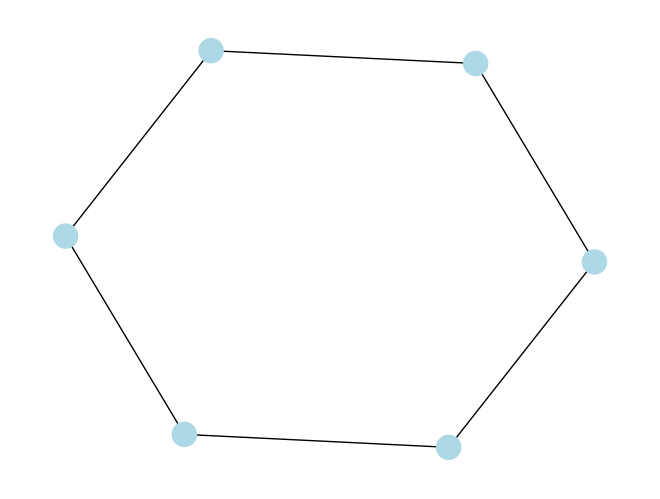

In [7]:
data, layer_edges, hex_cmap, graph = make_hex_lattice(
    hex_rows=hex_rows, hex_cols=hex_cols
)
num_qubits = len(data)
print(f"num_qubits = {num_qubits}")

# display the honeycomb lattice to simulate
node_colors = ["lightblue"] * len(graph.node_indices())
pos = rx.graph_spring_layout(
    graph,
    k=5/np.sqrt(num_qubits), 
    repulsive_exponent=1,  
    num_iter=150,  
)
mpl_draw(graph, node_color=node_colors, pos=pos)
plt.show()

To probe the spin dynamics, we study the average magnetization of the spins at each site as a function of Trotter steps. Hence, we construct the following observable:

$$
\langle O\rangle =  \frac{1}{N} \sum_i \langle Z_i \rangle
$$

In [8]:
observables_unitary = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1 / num_qubits) for i in range(num_qubits)],
    num_qubits=num_qubits,
)

### 1.1 Build unitary circuits

With the problem size and parameters specified, we are now ready to build the parametrized circuit that simulates the Trotterized time evolution of $U(\theta)$ with different Trotter steps, specified by the `depth` argument. The circuit we construct has alternating layers of `Rx($\theta$)` gates and `Rzz` gates. The `Rzz` gates realize the ZZ interactions between coupled spins, which will be placed between each lattice site specified by the `layer_edges` argument.

In [9]:
def gen_hex_unitary(
    num_qubits=6,
    zz_angle=np.pi / 8,
    layer_edges=[
        [(0, 1), (2, 3), (4, 5)],
        [(1, 2), (3, 4), (5, 0)],
    ],
    θ=Parameter("θ"),
    depth=1,
    measure=False,
    final_rot=True,
):
    circuit = QuantumCircuit(num_qubits)
    for _ in range(depth):
        for i in range(num_qubits):
            circuit.rx(θ, i)
        circuit.barrier()
        for coloring in layer_edges.keys():
            for e in layer_edges[coloring]:
                circuit.rzz(zz_angle, e[0], e[1])
        circuit.barrier()
    if final_rot:
        for i in range(num_qubits):
            circuit.rx(θ, i)
    if measure:
        circuit.measure_all()

    return circuit

Let's start with a small test example:

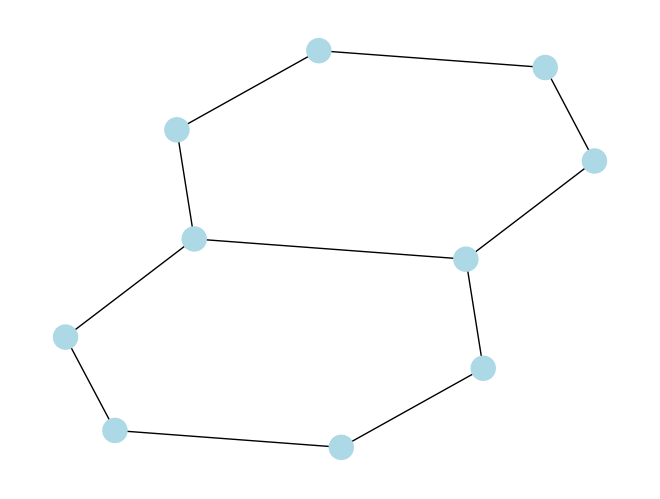

In [11]:
hex_rows_test = 1
hex_cols_test = 2

data_test, layer_edges_test, hex_cmap_test, graph_test = make_hex_lattice(
    hex_rows=hex_rows_test, hex_cols=hex_cols_test
) 

# display a small example for illustration
node_colors_test = ["lightblue"] * len(graph_test.node_indices())
pos = rx.graph_spring_layout(
    graph_test,
    k=5/np.sqrt(len(graph_test.nodes())), 
    repulsive_exponent=1,  
    num_iter=150,  
)
mpl_draw(graph_test, node_color=node_colors_test, pos=pos) 

Visualize the small test circuit:

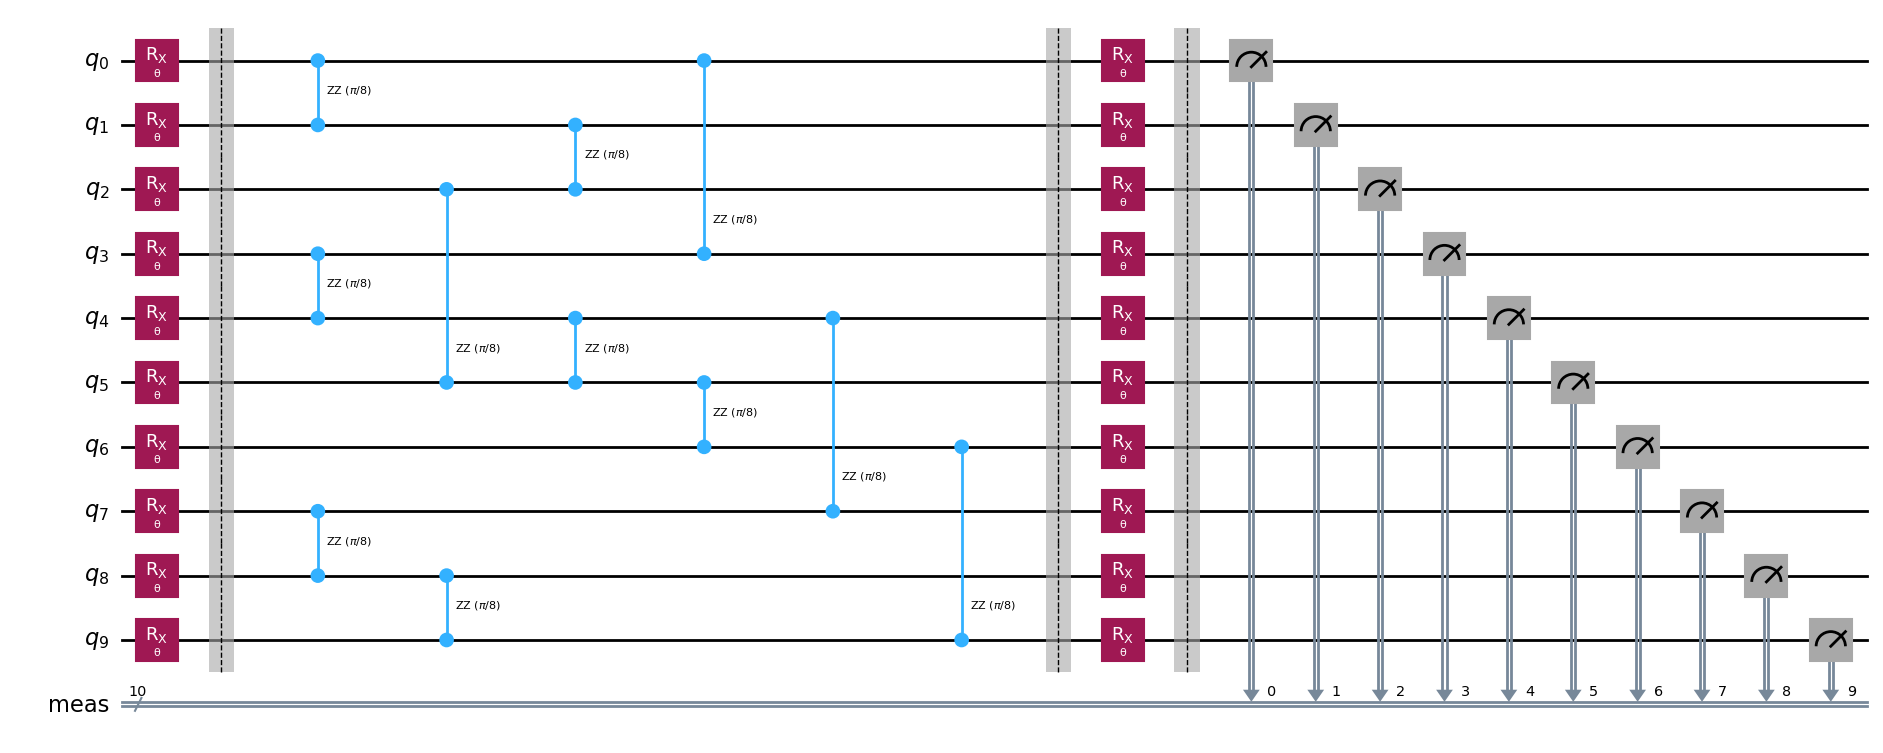

In [12]:
circ_unitary_test = gen_hex_unitary(
        num_qubits=len(data_test),
        layer_edges=layer_edges_test,
        θ=Parameter("θ"),
        depth=1,
        measure=True,
    )
circ_unitary_test.draw(output='mpl', fold=-1)

Similarly, construct the unitary circuits of the large example at differernt trotter steps.

In [13]:
circuits_unitary = []
for depth in depths:
    circ = gen_hex_unitary(
        num_qubits=num_qubits,
        layer_edges=layer_edges,
        θ=Parameter("θ"),
        depth=depth,
        measure=True,
    )
    circuits_unitary.append(circ)

### 1.2 Build dynamic circuit implementation

This section shows the main dynamic circuit implementation to simulate the same Trotterized time evolution. Note that the honeycomb lattice we want to simulate does not match the heavy lattice of the hardware qubits. One straightforward way to map the circuit to the hardware is to introduce a series of SWAP operations to bring interacting qubits next to each other, to realize the ZZ interaction. Here we highlight an alternative approach using dynamic circuits as a solution to illustrate that we can use the combination of quantum and real-time classical computation within a circuit in Qiskit to realize interactions beyond nearest-neighbor. 

In the dynamic circuit implementation, the ZZ interaction is effectively implemented by using ancilla qubits, mid-circuit measurement, and feed-forward. To understand this, note that the ZZ rotations apply a phase factor $e^{i\theta}$ to the state based on its parity. For two qubits, the computational basis states are $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$. The ZZ rotation gate applies a phase factor to states $|01\rangle$ and $|10\rangle$ whose parity (the number of `1`s in the state) is odd and leaves even-parity states unchanged. The following describes how we can effectively implement ZZ interactions on two qubits using dynamic circuits.





1. Compute parity into an ancilla qubit: Instead of directly applying ZZ to two qubits, we introduce a third qubit, the ancilla qubit, to store the parity information of the two data qubits. We entangle the ancilla with each data qubit using CX gates from the data qubit to the ancilla qubit.  



2. Apply a single-qubit Z rotation to the ancilla qubit: This is because the ancilla has the parity information of the two data qubits, which effectively implements the ZZ rotation on the data qubits.



3. Measure the ancilla qubit in the X basis: this is the key step that collapses the state of the ancilla qubit, and the measurement outcome tells us what has happened:

    * Measure 0: When a 0 outcome is observed, we have in fact correctly applied a ZZ(θ) rotation to our data qubits.

    * Measure 1: When a 0 outcome is observed, We've applied $ZZ(\theta + \pi)$ instead.



4. Apply correction gate when measuring 1: If we measured 1, we apply Z gates to the data qubits to "fix" the extra $\pi$ phase.

    

The resulting circuit is the following:

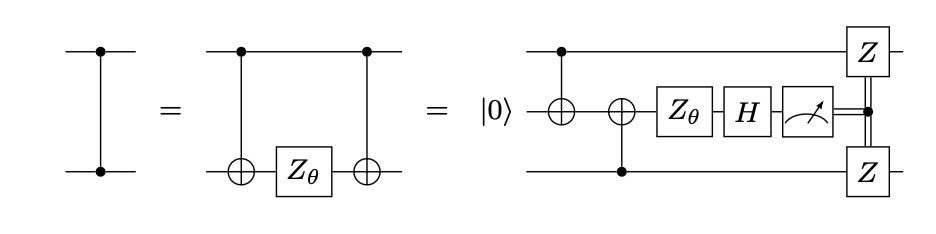

When we adopt this approach to simulate a honeycomb lattice, the resulting circuit embeds perfectly into the hardware with a heavy-hex lattice: all data qubits reside on the degree-3 sites of the lattice, which forms a hexagonal lattice. Every pair of data qubits shares an ancilla qubit residing on a degree-2 site. Below, we construct the qubit lattice for the dynamic circuit implementation, introducing ancilla qubits (shown in the darker purple circles). 

In [14]:
def make_lattice(hex_rows=1, hex_cols=1):
    # define lattice (change rows and cols to get larger lattices)
    hex_cmap = CouplingMap.from_hexagonal_lattice(
        hex_rows, hex_cols, bidirectional=False
    )
    data = list(hex_cmap.physical_qubits)

    heavyhex_cmap = CouplingMap()
    for d in data:
        heavyhex_cmap.add_physical_qubit(d)

    a = len(data)
    for edge in hex_cmap.get_edges():
        heavyhex_cmap.add_physical_qubit(a)
        heavyhex_cmap.add_edge(edge[0], a)
        heavyhex_cmap.add_edge(edge[1], a)
        a += 1
    ancilla = list(range(len(data), a))
    qubits = data + ancilla

    # color edges
    graph = heavyhex_cmap.graph.to_undirected(multigraph=False)
    edge_colors = rx.graph_misra_gries_edge_color(graph)
    layer_edges = {color: [] for color in edge_colors.values()}
    for edge_index, color in edge_colors.items():
        layer_edges[color].append(graph.edge_list()[edge_index])

    obs_hex = SparsePauliOp.from_sparse_list(
        [("Z", [i], 1 / len(data)) for i in data],
        num_qubits=len(qubits),
    )

    return (
        data,
        qubits,
        ancilla,
        layer_edges,
        heavyhex_cmap,
        graph,
        obs_hex,
    )

Visualize the heavyhex lattice for data qubits and ancilla qubits at a small scale:

number of data qubits = 6
number of ancilla qubits = 6


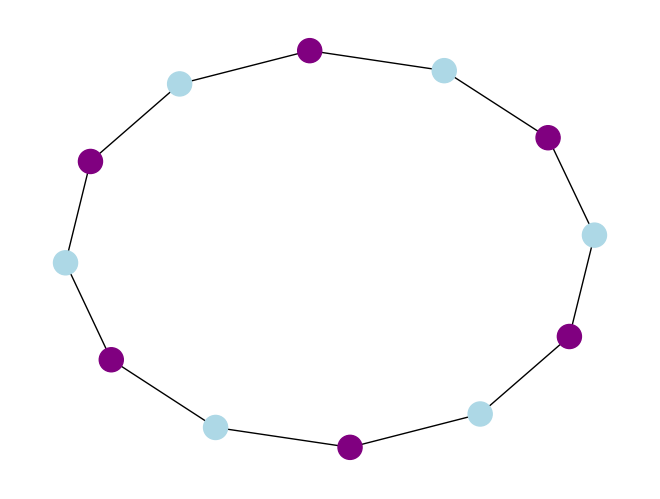

In [15]:
(
    data,
    qubits,
    ancilla,
    layer_edges,
    heavyhex_cmap,
    graph,
    obs_hex,
) = make_lattice(hex_rows=hex_rows, hex_cols=hex_cols)

print(f"number of data qubits = {len(data)}")
print(f"number of ancilla qubits = {len(ancilla)}")
node_colors = []
for node in graph.node_indices():
    if node in ancilla:
        node_colors.append("purple")
    else:
        node_colors.append(
            "lightblue"
        )  

pos = rx.graph_spring_layout(
    graph,
    k=1/np.sqrt(len(qubits)), 
    repulsive_exponent=2,  
    num_iter=200,  
)

# Draw with custom node colors
mpl_draw(graph, node_color=node_colors, pos=pos)
plt.show()

Below, we construct the dynamic circuit for the Trotterized time evolution. The `RZZ` gates are replaced with the dynamic circuit implementation using the steps described above. 

In [16]:
def gen_hex_dynamic(
    depth=1,
    zz_angle=np.pi / 8,
    θ=Parameter("θ"),
    hex_rows=1,
    hex_cols=1,
    measure=False,
    add_dd=True,
):

    (
        data,
        qubits,
        ancilla,
        layer_edges,
        heavyhex_cmap,
        graph,
        obs_hex,
    ) = make_lattice(hex_rows=hex_rows, hex_cols=hex_cols)
    qr = QuantumRegister(len(qubits), "qr")
    cr = ClassicalRegister(len(ancilla), "cr")
    circuit = QuantumCircuit(qr, cr)
    for d in data:
        circuit.rx(θ, d)

    for k in range(depth):
        circuit.barrier()
        for same_color_edges in layer_edges.values():
            for e in same_color_edges:
                circuit.cx(e[0], e[1])
        circuit.barrier()
        for a in ancilla:
            circuit.rz(zz_angle, a)
            circuit.h(a)
        #####need this to align terminal measurement
        circuit.barrier()

        for i, a in enumerate(ancilla):
            circuit.measure(a, i)
        d2ros = {}
        a2ro = {}
        for a in ancilla:
            a2ro[a] = cr[ancilla.index(a)]
        for d in data:
            ros = [a2ro[a] for a in heavyhex_cmap.neighbors(d)]
            d2ros[d] = ros
        for d in data:
            if add_dd:
                circuit = add_stretch_dd(
                    circuit, d, f"data_{d}_depth_{k}"
                )
            ros = d2ros[d]
            parity = ros[0]
            for ro in ros[1:]:
                parity = expr.bit_xor(parity, ro)
            with circuit.if_test(expr.equal(parity, True)):
                circuit.z(d)
        for a in ancilla:
            with circuit.if_test(expr.equal(a2ro[a], True)):
                circuit.x(a)
        circuit.barrier()
        for d in data:
            circuit.rx(θ, d)
    if measure:
        circuit.measure_all()

    return circuit, obs_hex


def add_stretch_dd(qc, q, name):
    s = qc.add_stretch(name)
    qc.delay(s, q)
    qc.rx(np.pi, q)
    qc.delay(s, q)
    qc.delay(s, q)
    qc.rx(-np.pi, q)
    qc.delay(s, q)
    return qc

#### 1.2.1 Dynamical decoupling (DD) and support for `stretch` duration 

One caveat of using the dynamic circuit implementation to realize the ZZ interaction is that the mid-circuit measurement and the classical feed-forward operations typically take a longer time to execute than quantum gates. To suppress qubit decoherence during the idling time for the classical operations to happen, we added a [dynamical decoupling](https://quantum.cloud.ibm.com/docs/en/guides/error-mitigation-and-suppression-techniques#dynamical-decoupling) (DD) sequence after the measurement operation on the ancilla qubits, and before the conditional Z operation on the data qubit, before the `if_test` statement. 

The DD sequence is added by the function `add_stretch_dd()`, which uses the [`stretch` durations](https://quantum.cloud.ibm.com/docs/guides/stretch) to determine the time intervals between the DD gates. A `stretch` duration is a way to specify a stretchable time duration for the `delay` operation such that the delay duration can grow to fill up the qubit idling time. The duration variables specified by `stretch` are resolved at compile time into desired durations that satisfy a certain constraint. This is very useful when the timing of DD sequences is essential to achieve good error suppression performance. For more details on the `stretch` type, please see the [OpenQASM](https://openqasm.com/language/delays.html#duration-and-stretch-types) documentation. Currently, support for the `stretch` type in Qiskit Runtime is experimental. For details on its usage constraints, please refer to [this page](https://quantum.cloud.ibm.com/docs/en/guides/stretch#qiskit-runtime-limitations).

Using the functions defined above, we build the Trotterized time evolution circuits, with and without DD, and the corresponding observables.

We start by visualizing the dynamic circuit of a small example:

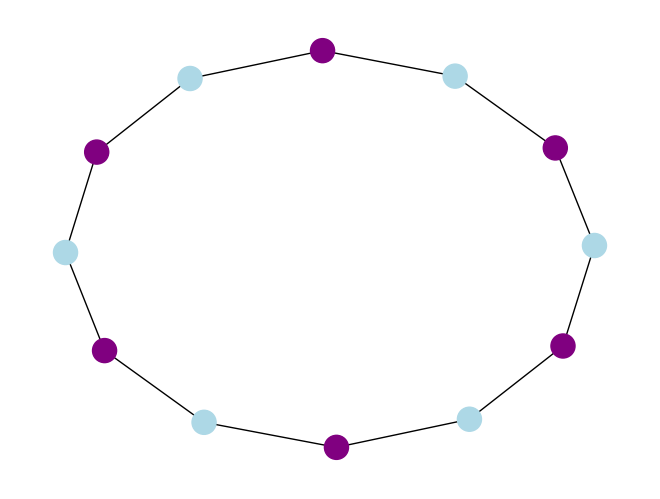

In [17]:
hex_rows_test = 1
hex_cols_test = 1

(
    data_test,
    qubits_test,
    ancilla_test,
    layer_edges_test,
    heavyhex_cmap_test,
    graph_test,
    obs_hex_test,
) = make_lattice(hex_rows=hex_rows_test, hex_cols=hex_cols_test)

node_colors = []
for node in graph_test.node_indices():
    if node in ancilla_test:
        node_colors.append("purple")
    else:
        node_colors.append(
            "lightblue"
        )
pos = rx.graph_spring_layout(
    graph_test,
    k=5/np.sqrt(len(qubits_test)), 
    repulsive_exponent=2,  
    num_iter=150,  
)

# display a small example for illustration
node_colors_test = ["lightblue"] * len(graph_test.node_indices())
mpl_draw(graph_test, node_color=node_colors, pos=pos) 

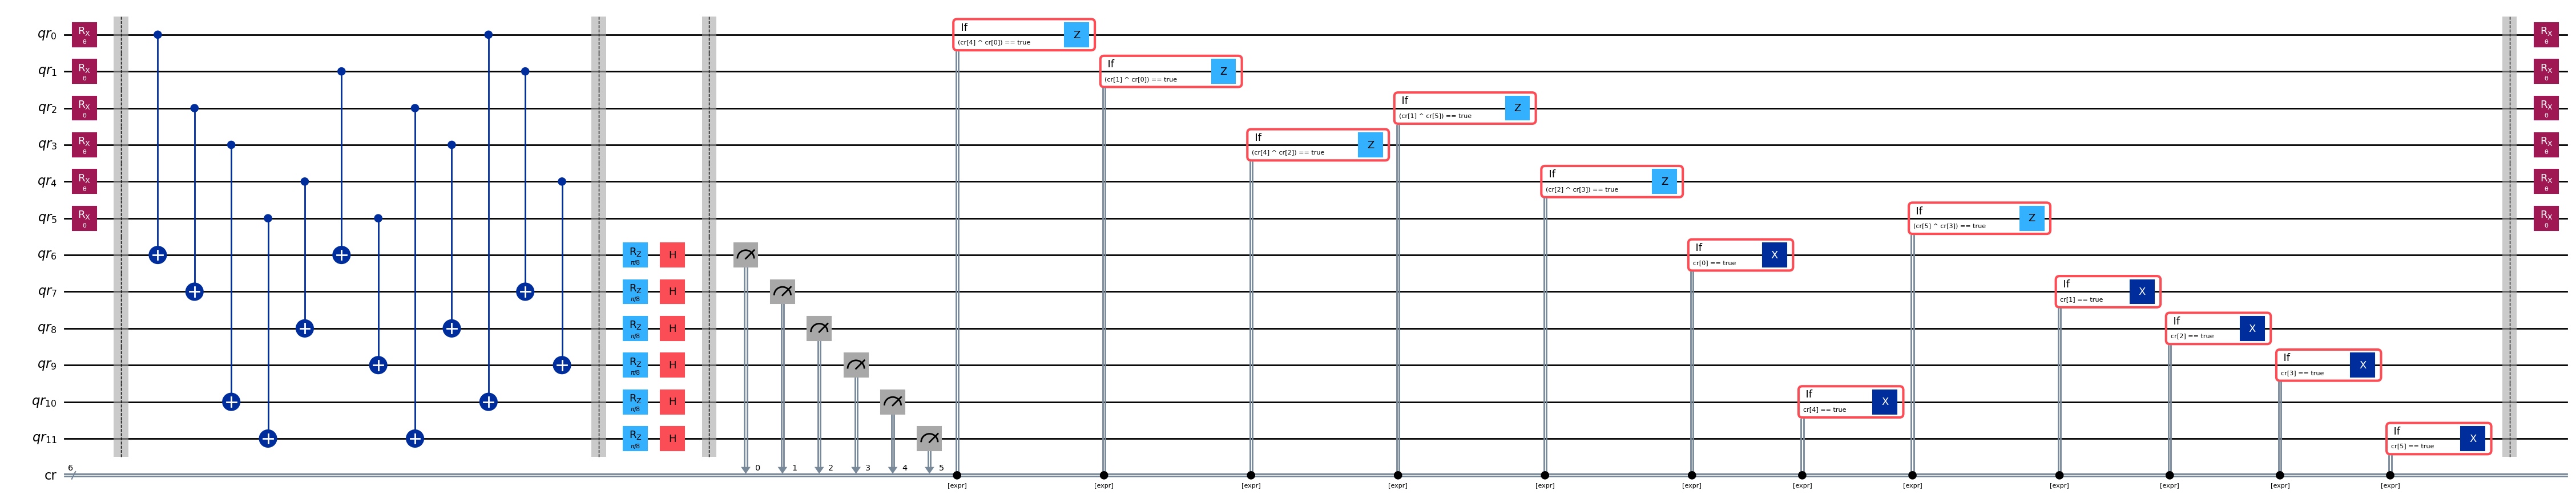

In [18]:
circuit_dynamic_test, _ = gen_hex_dynamic(
        depth=1,
        θ=Parameter("θ"),
        hex_rows=hex_rows_test,
        hex_cols=hex_cols_test,
        measure=False,
        add_dd=False,
    )
circuit_dynamic_test.draw('mpl', fold=-1)

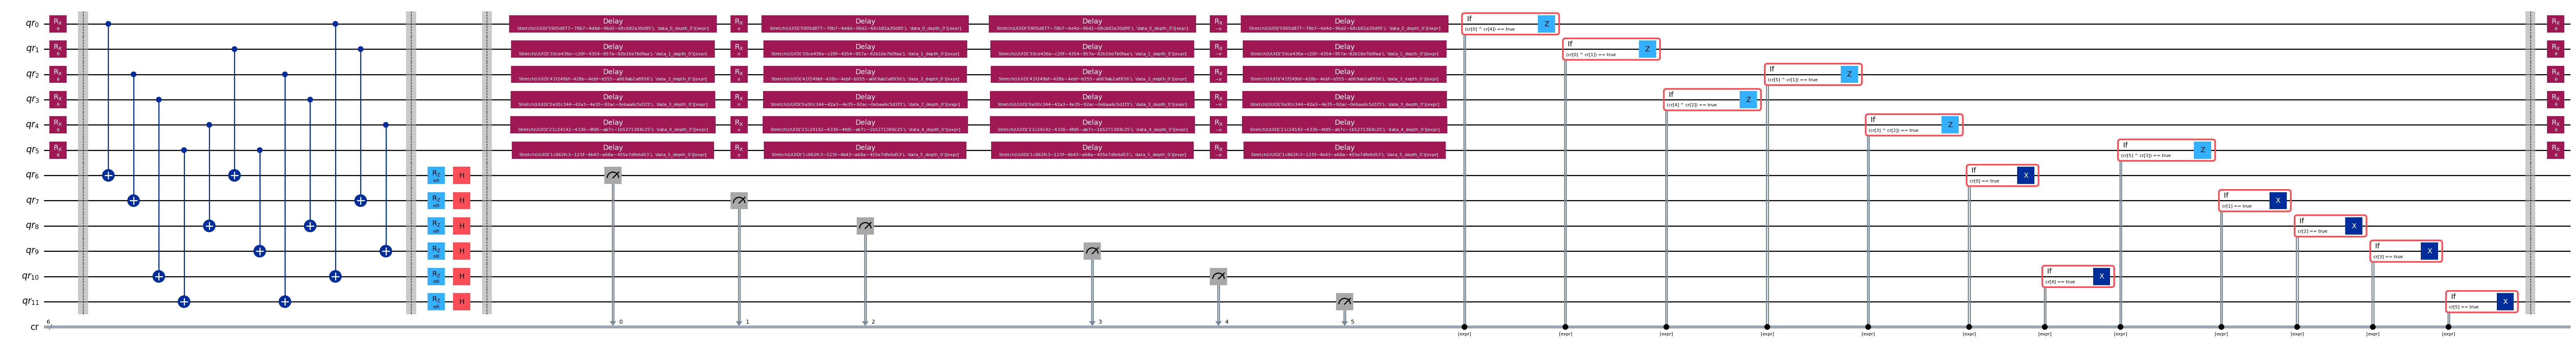

In [19]:
circuit_dynamic_dd_test, _ = gen_hex_dynamic(
    depth=1,
    θ=Parameter("θ"),
    hex_rows=hex_rows_test,
    hex_cols=hex_cols_test,
    measure=False,
    add_dd=True,
)
circuit_dynamic_dd_test.draw('mpl', fold=-1)

Similarly, construct the dynamic circuits for the large example:

In [20]:
circuits_dynamic = []
circuits_dynamic_dd = []
observables_dynamic = []
for depth in depths:
    circuit, obs = gen_hex_dynamic(
        depth=depth,
        θ=Parameter("θ"),
        hex_rows=hex_rows,
        hex_cols=hex_cols,
        measure=True,
        add_dd=False,
    )
    circuits_dynamic.append(circuit)

    circuit_dd, _ = gen_hex_dynamic(
        depth=depth,
        θ=Parameter("θ"),
        hex_rows=hex_rows,
        hex_cols=hex_cols,
        measure=True,
        add_dd=True,
    )
    circuits_dynamic_dd.append(circuit_dd)
    observables_dynamic.append(obs)

## Step 2: Optimize for hardware execution

We are now ready to transpile the circuit to the hardware. We will transpile both the unitary standard implementation and the dynamic circuit implementation to the hardware.

### 2.1 Stardard transpilation for unitary circuits

As a comparison to the dynamic circuit implementation, we use the standard transpiler with the preset pass manager. 

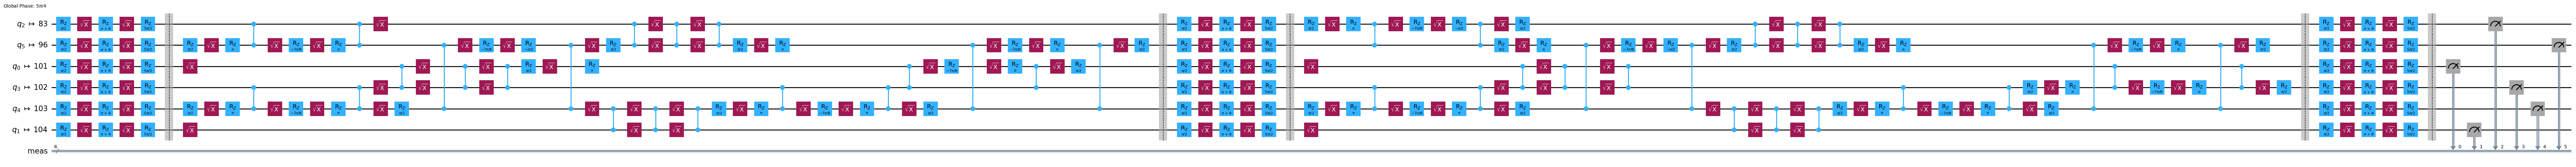

In [21]:
qc = circuits_unitary[2]

pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)
tqc = pm.run(qc)

tqc.draw("mpl", idle_wires=False, fold=-1)

To ensure we use the same set of physical qubits in all circuits for more consistent results, we transpile to a set of the physical qubits specified by `initial_layout`, and then construct the [primitive unified blocs](https://quantum.cloud.ibm.com/docs/guides/primitive-input-output) (PUBs) as the Sampler primitive input.

In [22]:
def get_used_qubit_mapping(qc: QuantumCircuit):
    """Get used physical qubits from a transpiled circuit"""
    qubits = []
    for (
        key,
        value,
    ) in qc.layout.initial_layout.get_physical_bits().items():
        if value._register.name == "q":
            qubits.append(key)
    return qubits


def transpile_minimize(
    circ: QuantumCircuit, pm: PassManager, iterations=10
):
    """Transpile circuits for specified number of iterations and return the one with smallest two-qubit gate depth"""
    circs = [pm.run(circ) for i in range(iterations)]
    circs_sorted = sorted(
        circs,
        key=lambda x: x.depth(
            lambda x: x.operation.num_qubits == 2
        ),
    )
    return circs_sorted[0]


init_layout = get_used_qubit_mapping(tqc)

pm = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    initial_layout=init_layout,
)
unitary_isa_circuits = []
for circ in circuits_unitary:
    circ_t = transpile_minimize(circ, pm, iterations=100)
    unitary_isa_circuits.append(circ_t)

unitary_pubs = [(circ, params) for circ in unitary_isa_circuits]

### 2.2 Transpilation for dynamic circuits
Similarly, we transpile the dynamic circuits, with and without adding the DD sequence, and construct the corresponding PUBs.

In [23]:
pm = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
)

dynamic_isa_circuits = [pm.run(circ) for circ in circuits_dynamic]
dynamic_pubs = [(circ, params) for circ in dynamic_isa_circuits]

dynamic_isa_circuits_dd = [
    pm.run(circ) for circ in circuits_dynamic_dd
]
dynamic_pubs_dd = [
    (circ, params) for circ in dynamic_isa_circuits_dd
]

We can visualize the qubit layout and the transpiled circuit below.

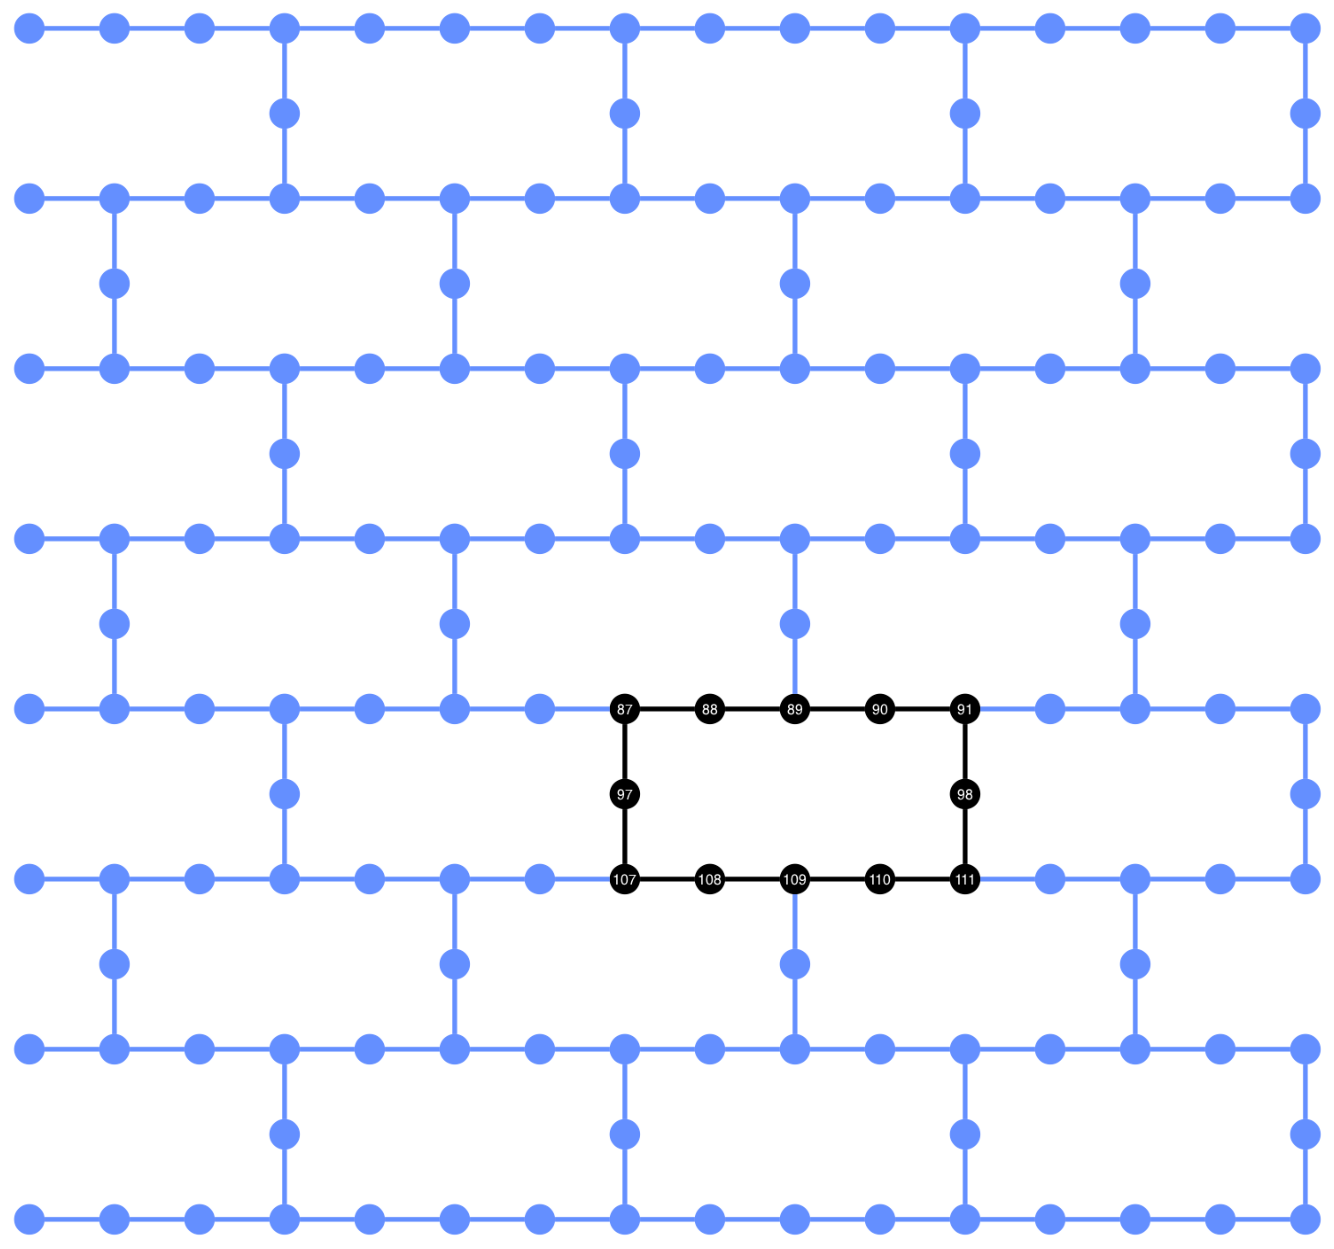

In [24]:
def _heron_coords_r2():
    cord_map = np.array(
        [
            [
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                3,
                7,
                11,
                15,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                1,
                5,
                9,
                13,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                3,
                7,
                11,
                15,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                1,
                5,
                9,
                13,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                3,
                7,
                11,
                15,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                1,
                5,
                9,
                13,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                3,
                7,
                11,
                15,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
            ],
            -1
            * np.array(
                [
                    j
                    for i in range(15)
                    for j in [i] * [16, 4][i % 2]
                ]
            ),
        ],
        dtype=int,
    )

    hcords = []
    ycords = cord_map[0]
    xcords = cord_map[1]
    for i in range(156):
        hcords.append([xcords[i] + 1, np.abs(ycords[i]) + 1])

    return hcords


plot_circuit_layout(
    dynamic_isa_circuits_dd[8],
    backend,
    qubit_coordinates=_heron_coords_r2(),
    view="physical",
)

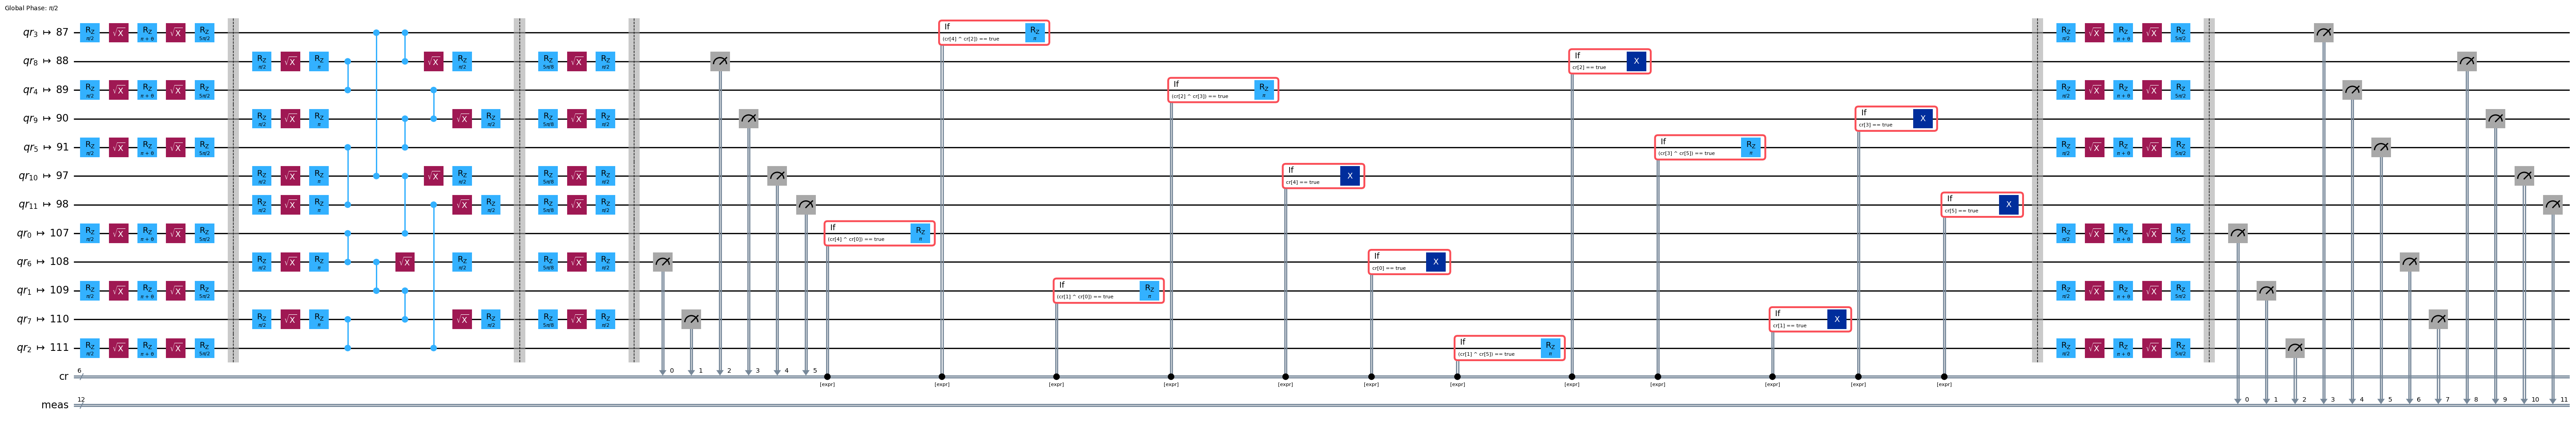

In [25]:
dynamic_isa_circuits[1].draw(
    fold=-1, output="mpl", idle_wires=False
)

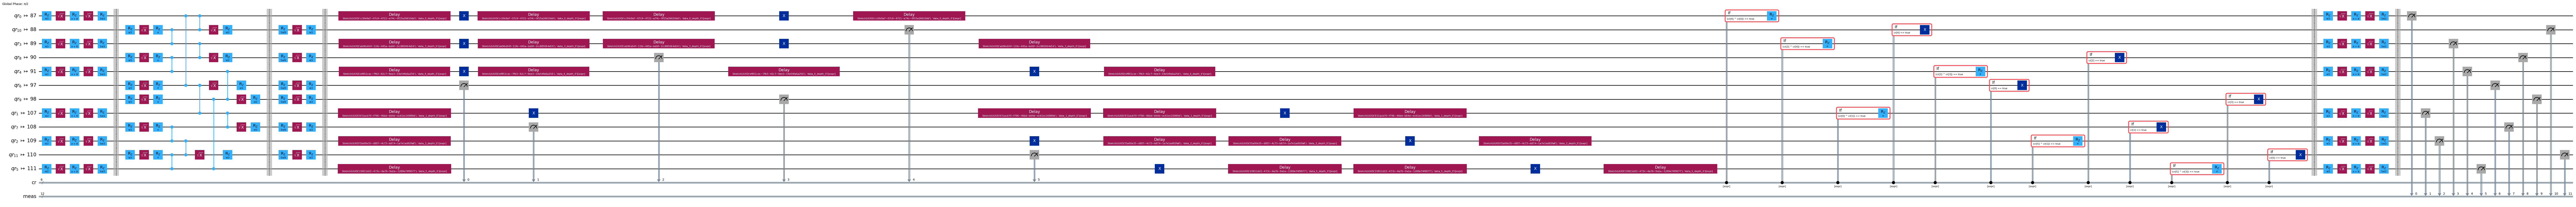

In [26]:
dynamic_isa_circuits_dd[1].draw(
    fold=-1, output="mpl", idle_wires=False
)

#### 2.2.1 Transpile using `MidCircuitMeasure` 

The `MidCircuitMeasure` is an addition to the available measurement operations, calibrated specifically to perform [mid-circuit measurements](https://quantum.cloud.ibm.com/docs/en/guides/measure-qubits#mid-circuit-measurements). The `MidCircuitMeasure` instruction maps to the `measure_2` instruction supported by the backends. Note that `measure_2` is not supported on all backends. You can use `service.backends(filters=lambda b: "measure_2" in b.supported_instructions)` to find backends that support it. Here, we show how to transpile the circuit so that the mid-circuit measurements defined in the circuit are executed using the `MidCircuitMeasure` operation, if the backend supports it.

Below, we print the duration for the `measure_2` instruction and the standard `measure` instruction.

In [27]:
print(f'Mid-circuit measurement `measure_2` duration:  {backend.instruction_durations.get('measure_2',0) * backend.dt * 1e9/1e3} μs')
print(f'Terminal measurement `measure` duration: {backend.instruction_durations.get('measure',0) * backend.dt *1e9/1e3} μs')

Mid-circuit measurement `measure_2` duration:  1.76 μs
Terminal measurement `measure` duration: 2.28 μs


In [28]:
"""Pass that replaces terminal measures in the middle of the circuit with
MidCircuitMeasure instructions."""


class ConvertToMidCircuitMeasure(TransformationPass):
    """This pass replaces terminal measures in the middle of the circuit with
    MidCircuitMeasure instructions.
    """

    def __init__(self, target):
        super().__init__()
        self.target = target

    def run(self, dag):
        """Run the pass on a dag."""
        mid_circ_measure = None
        for inst in self.target.instructions:
            if isinstance(inst[0], Instruction) and inst[
                0
            ].name.startswith("measure_"):
                mid_circ_measure = inst[0]
                break
        if not mid_circ_measure:
            return dag

        final_measure_nodes = calc_final_ops(dag, {"measure"})
        for node in dag.op_nodes(Measure):
            if node not in final_measure_nodes:
                dag.substitute_node(
                    node, mid_circ_measure, inplace=True
                )

        return dag


pm = PassManager(ConvertToMidCircuitMeasure(backend.target))

dynamic_isa_circuits_meas2 = [
    pm.run(circ) for circ in dynamic_isa_circuits
]
dynamic_pubs_meas2 = [
    (circ, params) for circ in dynamic_isa_circuits_meas2
]

dynamic_isa_circuits_dd_meas2 = [
    pm.run(circ) for circ in dynamic_isa_circuits_dd
]
dynamic_pubs_dd_meas2 = [
    (circ, params) for circ in dynamic_isa_circuits_dd_meas2
]

### 2.3 Compare two-qubit gate depth of unitary and dynamic circuits

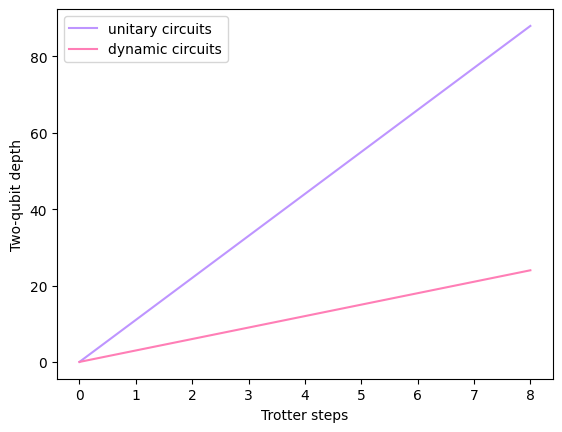

In [29]:
# compare circuit depth of unitary and dynamic circuit implementations
unitary_depth = [
    unitary_isa_circuits[i].depth(
        lambda x: x.operation.num_qubits == 2
    )
    for i in range(len(unitary_isa_circuits))
]

dynamic_depth = [
    dynamic_isa_circuits[i].depth(
        lambda x: x.operation.num_qubits == 2
    )
    for i in range(len(dynamic_isa_circuits))
]

plt.plot(
    list(range(len(unitary_depth))),
    unitary_depth,
    label="unitary circuits",
    color="#be95ff",
)
plt.plot(
    list(range(len(dynamic_depth))),
    dynamic_depth,
    label="dynamic circuits",
    color="#ff7eb6",
)
plt.xlabel("Trotter steps")
plt.ylabel("Two-qubit depth")
plt.legend()

The main benefit of the measurement-based circuit is that, when implementing multiple ZZ interactions, the CX layers can be parallelized, and measurements can occur simultaneously. This is because all ZZ interactions commute, so the computation can be performed with measurement depth 1. After transpiling the circuits, we observe that the dynamic circuit approach yields a shorter two-qubit depth than the standard unitary approach.

## Step 3: Execute on hardware

With the circuits and observables prepared, we now execute them on hardware using the Sampler primitive.  

Here we submit three jobs for `unitary_pubs`, `dynamic_pubs`, and `dynamic_pubs_dd`. Each is a list of parametrized circuits corresponding to nine different Trotter steps with three different $\theta$ parameters.

In [30]:
shots = 10000
use_cached_results = False

if use_cached_results:
    job_unitary = shared_service.job("d46cind63mfc73a7t51g")
    job_dynamic = shared_service.job("d46cinmjf4ms73apjl00")
    job_dynamic_dd = shared_service.job("d46cio563mfc73a7t52g")
    job_dynamic_meas2 = shared_service.job("d46ciomjf4ms73apjl10")
    job_dynamic_dd_meas2 = shared_service.job("d46cip6n7jjs73bth870")
else:
    with Batch(backend=backend) as batch:
        sampler = Sampler(mode=batch)

        sampler.options.experimental = {
            "execution": {
                "scheduler_timing": True
            },  # set to True to retrieve circuit timeing info
        }

        job_unitary = sampler.run(unitary_pubs, shots=shots)
        print(f"unitary: {job_unitary.job_id()}")

        job_dynamic = sampler.run(dynamic_pubs, shots=shots)
        print(f"dynamic: {job_dynamic.job_id()}")

        job_dynamic_dd = sampler.run(dynamic_pubs_dd, shots=shots)
        print(f"dynamic_dd: {job_dynamic_dd.job_id()}")

        job_dynamic_meas2 = sampler.run(
            dynamic_pubs_meas2, shots=shots
        )
        print(f"dynamic_meas2: {job_dynamic_meas2.job_id()}")

        job_dynamic_dd_meas2 = sampler.run(
            dynamic_pubs_dd_meas2, shots=shots
        )
        print(f"dynamic_dd_meas2: {job_dynamic_dd_meas2.job_id()}")

unitary: d4b7cj1lag1s73bkuveg
dynamic: d4b7cj7nmdfs73adjnvg
dynamic_dd: d4b7cja489vs73a35lp0
dynamic_meas2: d4b7cja489vs73a35lpg
dynamic_dd_meas2: d4b7cjci51bc738ipkv0


## Step 4: Post-process and visualize results

After the jobs are completed, we can retrieve the circuit duration from the job results metadata and visualize the circuit schedule information. To read more about visualizing a circuit's scheduling information, refer to [this page](https://quantum.cloud.ibm.com/docs/en/guides/visualize-circuit-timing#qiskit-runtime-support).

In [ ]:
# Circuit durations is reported in the unit of `dt` which can be retrieved from `Backend` object
unitary_durations = [
    job_unitary.result()[i].metadata["compilation"][
        "scheduler_timing"
    ]["circuit_duration"]
    for i in depths
]

dynamic_durations = [
    job_dynamic.result()[i].metadata["compilation"][
        "scheduler_timing"
    ]["circuit_duration"]
    for i in depths
]

dynamic_durations_meas2 = [
    job_dynamic_meas2.result()[i].metadata["compilation"][
        "scheduler_timing"
    ]["circuit_duration"]
    for i in depths
]

result_dd = job_dynamic_dd.result()[1]
circuit_schedule_dd = result_dd.metadata["compilation"][
    "scheduler_timing"
]["timing"]

# to visualize the circuit schedule, one can show the figure below
fig_dd = draw_circuit_schedule_timing(
    circuit_schedule=circuit_schedule_dd,
    included_channels=None,
    filter_readout_channels=False,
    filter_barriers=False,
    width=1000,
)

# Save to a file since the figure is large
fig_dd.write_html("scheduler_timing_dd.html")

We plot the circuit durations for unitary circuits and the dynamic circuits. From the plot below, we confirm that the dynamic circuit implementation results in a significantly shorter circuit duration. In the case of the dynamic circuits with `measure_2`, the circuit duration is reduced by nearly half.

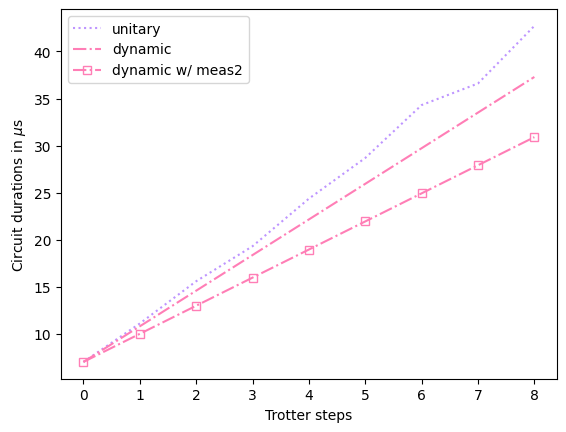

In [ ]:
# visualize circuit durations

def convert_dt_to_microseconds(circ_duration: List, backend_dt: float):
    dt = backend_dt * 1e6 # dt in microseconds
    return list(map(lambda x: x * dt, circ_duration))

dt = backend.target.dt
plt.plot(
    depths,
    convert_dt_to_microseconds(unitary_durations, dt),
    color="#be95ff",
    linestyle=":",
    label="unitary",
)
plt.plot(
    depths,
    convert_dt_to_microseconds(dynamic_durations, dt),
    color="#ff7eb6",
    linestyle="-.",
    label="dynamic",
)
plt.plot(
    depths,
    convert_dt_to_microseconds(dynamic_durations_meas2, dt),
    color="#ff7eb6",
    linestyle="-.",
    marker="s",
    mfc="none",
    label="dynamic w/ meas2",
)

plt.xlabel("Trotter steps")
plt.ylabel(r"Circuit durations in $\mu$s")
plt.legend()

After the jobs are completed, we retrieve the data below and compute the average magnetization estimated by the observables `observables_unitary` or `observables_dynamic` we constructed earlier.

In [ ]:
runs = {
    "unitary": (
        job_unitary,
        [observables_unitary] * len(circuits_unitary),
    ),
    # Omitting Dyn w/o DD and Dynamic w/ DD plots for better readability
    # "dynamic": (job_dynamic, observables_dynamic),
    # "dynamic_dd": (job_dynamic_dd, observables_dynamic),
    "dynamic_meas2": (job_dynamic_meas2, observables_dynamic),
    "dynamic_dd_meas2": (
        job_dynamic_dd_meas2,
        observables_dynamic,
    ),
}

In [160]:
data_dict = {}
for key, (job, obs) in runs.items():
    data = []
    for i in range(points):
        data.append(
            [
                job.result()[ind]
                .data["meas"]
                .expectation_values(obs[ind])[i]
                for ind in depths
            ]
        )
    data_dict[key] = data

Below we plot the spin magnetization as a function of the Trotter steps at different $\theta$ values, corresponding to different strengths of the local magnetic field. We plot both the pre-computed MPS simulation results for the unitary ideal circuits, together with the experimental results from the following: 

1. running the unitary circuits
2. running the dynamic circuits with `MidCircuitMeasure`
3. running the dynamic circuits with DD and `MidCircuitMeasure`

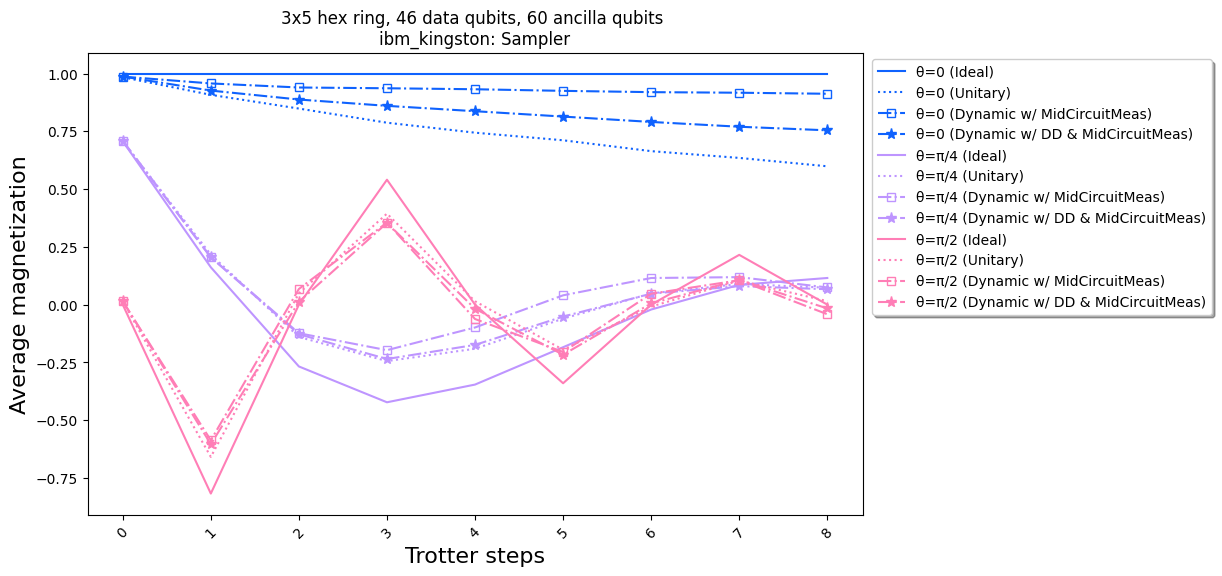

In [ ]:
plt.figure(figsize=(10, 6))

data_sim = np.real(np.load("MPS_sim/magnetization_3x3.npy"))

colors = ["#0f62fe", "#be95ff", "#ff7eb6"]
for i in range(points):
    plt.plot(
        depths,
        data_sim[i],
        color=colors[i],
        linestyle="solid",
        label=f"θ={pi_check(i*max_angle/(points-1))} (Ideal)",
    )
    plt.plot(
        depths,
        data_dict["unitary"][i],
        color=colors[i],
        linestyle=":",
        label=f"θ={pi_check(i*max_angle/(points-1))} (Unitary)",
    )

    # Omitting Dyn w/o DD and Dynamic w/ DD plots for better readability
    # plt.plot(
    #     depths,
    #     data_dict["dynamic"][i],
    #     color=colors[i],
    #     linestyle="-.",
    #     label=f"θ={pi_check(i*max_angle/(points-1))} (Dyn w/o DD)",
    # )
    # plt.plot(
    #     depths,
    #     data_dict["dynamic_dd"][i],
    #     marker="D",
    #     mfc="none",
    #     color=colors[i],
    #     linestyle="-.",
    #     label=f"θ={pi_check(i*max_angle/(points-1))} (Dynamic w/ DD)",
    # )

    plt.plot(
        depths,
        data_dict["dynamic_meas2"][i],
        marker="s",
        mfc="none",
        color=colors[i],
        linestyle="-.",
        label=f"θ={pi_check(i*max_angle/(points-1))} (Dynamic w/ MidCircuitMeas)",
    )

    plt.plot(
        depths,
        data_dict["dynamic_dd_meas2"][i],
        marker="*",
        markersize=8,
        color=colors[i],
        linestyle="-.",
        label=f"θ={pi_check(i*max_angle/(points-1))} (Dynamic w/ DD & MidCircuitMeas)",
    )


plt.xlabel("Trotter steps", fontsize=16)
plt.ylabel("Average magnetization", fontsize=16)
plt.xticks(rotation=45)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    labels,
    loc="upper right",
    bbox_to_anchor=(1.46, 1.0),
    shadow=True,
    ncol=1,
)
plt.title(
    f"{hex_rows}x{hex_cols} hex ring, {num_qubits} data qubits, {len(ancilla)} ancilla qubits \n{backend.name}: Sampler"
)
plt.show()

When we compare the experimental results with the simulation, we see that the dynamic circuit implementation (dashed-dotted line) overall has break-even performance with the standard unitary implementation (dotted line). Adding dynamical decoupling sequences helps in certain cases—for example, for $\theta=\pi/4$ or $\theta=\pi/2$ at certain Trotter steps. However, it does not help in other cases—for example, for $\theta=0$. In summary, we present dynamic circuits as a solution for simulating Ising spin models on a honeycomb lattice, a topology that is not native to the hardware. The dynamic circuit solution allows ZZ interactions between qubits that are not nearest neighbors, with a shorter two-qubit gate depth than using SWAP gates, at the cost of introducing extra ancilla qubits and classical feed-forward operations.

# References
- Quantum computing with Qiskit, by Javadi-Abhari, A., Treinish, M., Krsulich, K., Wood, C.J., Lishman, J., Gacon, J., Martiel, S., Nation, P.D., Bishop, L.S., Cross, A.W. and Johnson, B.R., 2024. arXiv preprint [arXiv:2405.08810 (2024)](https://arxiv.org/abs/2405.08810)